In [1]:
import autograd.numpy as np
import autograd.scipy as sp

import autograd

import sys
sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 

import functional_sensitivity_lib as fun_sens_lib
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)

import json 


# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

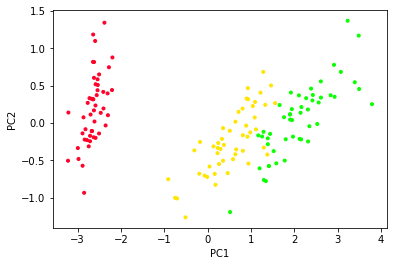

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

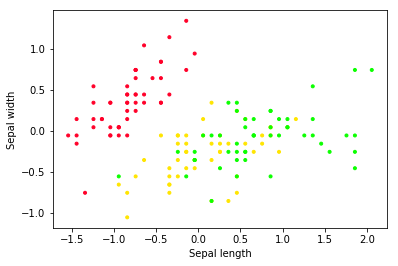

In [8]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(iris_features[:, 0], iris_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('Sepal length')
fig.set_ylabel('Sepal width')

In [9]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior params

In [10]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [11]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [12]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [13]:
set_truth = False

In [14]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [15]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

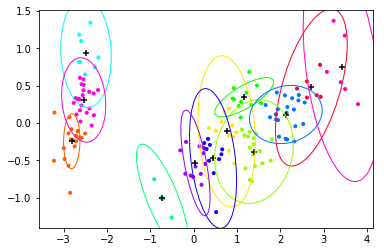

In [16]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [17]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


# Optimize!

In [18]:
load_from_disc = True

In [19]:
if not load_from_disc: 
    t0 = time.time()
    best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=100,
            final_max_iter=500)
    t_newton = time.time() - t0

    print('done. ')
    
else: 

    full_data_fit_file = '../iris_fits/full_data_fits/iris_bnp_full_data_fit.json'
    with open(full_data_fit_file, 'r') as fp:
        fit_dict = json.load(fp)

    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)

    best_param = model.global_vb_params.get_free()

In [20]:
newton_results = deepcopy(model)

In [21]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [22]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [23]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

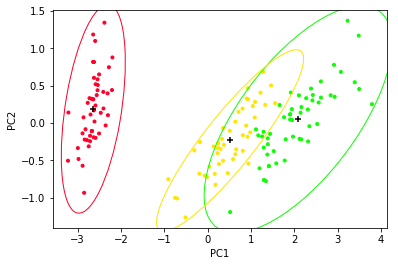

In [24]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
colors1_[0] = colors1[2]
colors1_[1] = colors1[0]
colors1_[2] = colors1[1]

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [25]:
# plt.scatter(pc_features[bnp_clusters == 0, 0], pc_features[bnp_clusters == 0, 1])

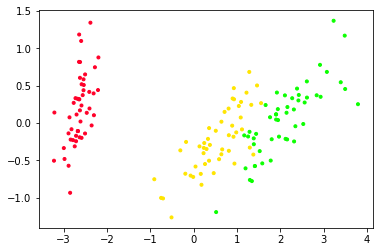

In [26]:
# recall true clustering
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

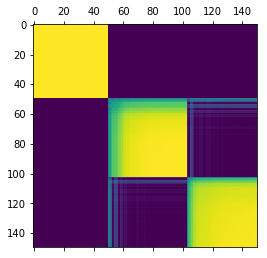

In [27]:
model.set_from_global_free_par(newton_results.global_vb_params.get_free())
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx_best = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]

plt.matshow(co_cluster_mat)


In [28]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

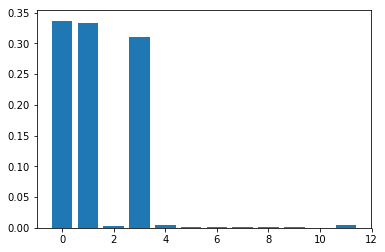

In [29]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

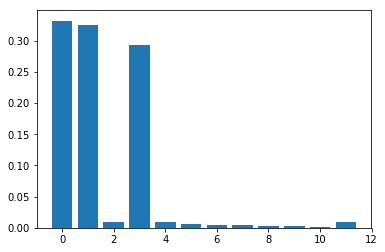

In [30]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  2.,   0.,   1.,   1.,   1.,   5.,   2.,   2.,   6., 130.]),
 array([0.44352936, 0.49917643, 0.55482349, 0.61047055, 0.66611762,
        0.72176468, 0.77741174, 0.83305881, 0.88870587, 0.94435294,
        1.        ]),
 <a list of 10 Patch objects>)

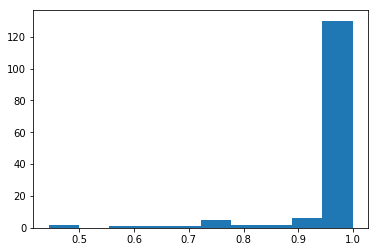

In [31]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Functional sensitivity

In [32]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = gmm_utils.LinearSensitivity(deepcopy(model), moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [33]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [34]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))

0.07230487288465379 2452.4187642002653


In [35]:
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [36]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)


# lets look at weights instead 
def get_kth_weight_from_free_param(model, free_par, k): 
    model.set_from_global_free_par(free_par)
    e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)
    
    return modeling_lib.get_kth_weight_from_sticks(np.array([e_sticks]), k)

g_eta = np.zeros((k_approx, model.global_vb_params.free_size()))
for k in range(k_approx): 
    get_g_eta = autograd.jacobian(get_kth_weight_from_free_param, argnum = 1)
    g_eta[k, :] = get_g_eta(model, best_param, k)

In [37]:
get_g_eta_nclust = autograd.jacobian(get_e_number_clusters_from_free_par, argnum = 1)
g_eta_nclust = get_g_eta_nclust(model, best_param)

# Worst case influence

In [60]:
worst_case_neg = lambda x : linear_sens.get_worst_case_perturbation_unscaled(g_eta = g_eta_nclust, \
                                                                      theta = x, \
                                                                      sign = -1)

worst_case_pos = lambda x : linear_sens.get_worst_case_perturbation_unscaled(g_eta = g_eta_nclust, \
                                                                      theta = x, \
                                                                      sign = 1)

In [208]:
theta = np.linspace(0.01, 0.99, 100)

In [209]:
epsilon = 0.01

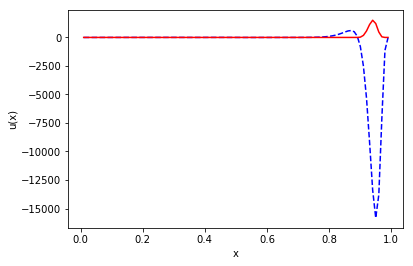

In [210]:
plt.plot(theta, np.dot(g_eta_nclust, linear_sens.total_influence_function(theta)), 'b--')
plt.plot(theta, worst_case_neg(theta).flatten() * epsilon, 'red')
plt.xlabel('x')
plt.ylabel('u(x)')
# plt.title('total influence on n_clusters')

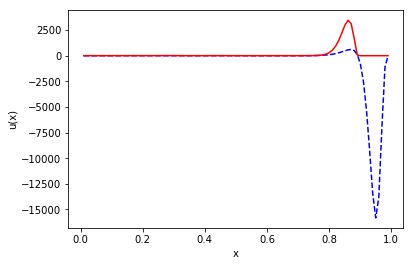

In [211]:
plt.plot(theta, np.dot(g_eta_nclust, linear_sens.total_influence_function(theta)), 'b--')
plt.plot(theta, worst_case_pos(theta).flatten(), 'red')
plt.xlabel('x')
plt.ylabel('u(x)')
# plt.title('total influence on n_clusters')

In [212]:
def eval_linear_interpolation(x, int_points_x, int_points_y): 
    # x are the values at which we want to evaluate the function
    # int_point_y are the true values of the function at int_point_x 
    
    # get the indices where x falls in int_points_x
    x_indices = np.searchsorted(int_points_x, x)
    x_indices = x_indices.clip(1, len(int_points_x)-1).astype(int)

    lo = x_indices - 1
    hi = x_indices

    # The actual points between which the x falls
    x_lo = int_points_x[lo]
    x_hi = int_points_x[hi]
    # the y values at those points
    y_lo = int_points_y[lo]
    y_hi = int_points_y[hi]
                      
    # get slope
    slope = (y_hi - y_lo) / (x_hi - x_lo)
    
    # return interplated value
    return slope*(x - x_lo) + y_lo

In [213]:
def eval_cubic_kernel(x, a):
    abs_x = np.abs(x)
    result_12 = np.where(np.logical_and(abs_x < 2, abs_x >=1),
                         a * abs_x**3 - 5 * a * abs_x**2 + 8 * a * abs_x - 4 * a,
                         np.zeros_like(x))

    result_01 = np.where(np.logical_and(abs_x < 1, abs_x >= 0),
                         (a + 2) * abs_x**3 - (a + 3) * abs_x**2 + 1,
                         np.zeros_like(x))

    return result_01 + result_12


In [66]:
# Get interpolating points
n_int_points = 10000
int_points_x_ = np.linspace(0.0, 1.0, n_int_points)
int_points_x = np.sort((1 - (np.power(10, int_points_x_) - 1) / 9) * (1 - 0.6e-6) + 0.5e-6)

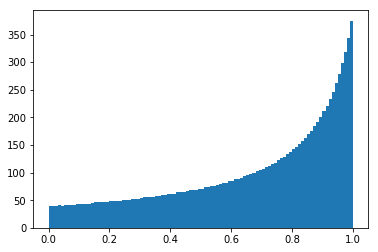

In [67]:
# plt.plot(int_points_x, np.zeros(len(int_points_x)), '.', alpha = 0.005)
plt.hist(int_points_x, bins = 100); 

In [68]:
int_points_x

array([5.00000000e-07, 2.56338763e-04, 5.12118617e-04, ...,
       9.99948715e-01, 9.99974310e-01, 9.99999900e-01])

In [69]:
np.max(int_points_x)

0.9999998999999999

In [70]:
np.min(int_points_x)

5e-07

In [71]:
worst_case_pos_int_points = \
    linear_sens.get_worst_case_perturbation_unscaled(g_eta = g_eta_nclust, \
                                                      theta = int_points_x, \
                                                      diffble = False, \
                                                      sign = 1).flatten()
worst_case_neg_int_points = \
    linear_sens.get_worst_case_perturbation_unscaled(g_eta = g_eta_nclust, \
                                                      theta = int_points_x, \
                                                      diffble = False, \
                                                      sign = -1).flatten()

In [72]:
# plt.plot(int_points_x, worst_case_neg_int_points, 'blue')
# plt.plot(theta, worst_case_neg(theta).flatten(), 'red')

In [73]:
worst_case_pos_interpolated = lambda x : eval_linear_interpolation(x, int_points_x, worst_case_pos_int_points)
worst_case_neg_interpolated = lambda x : eval_linear_interpolation(x, int_points_x, worst_case_neg_int_points)

In [74]:
x = np.random.random((100))

print('absolute diff')
print(np.max(np.abs(worst_case_pos_interpolated(x) - worst_case_pos(x))))
print(np.max(np.abs(worst_case_neg_interpolated(x) - worst_case_neg(x))))

# print('\n relative diff')
# print(np.max(np.abs(worst_case_pos_interpolated(x) - worst_case_pos(x) / worst_case_pos(x))))
# print(np.max(np.abs(worst_case_neg_interpolated(x) - worst_case_neg(x) / worst_case_neg(x))))

absolute diff
0.004356710524916707
0.04988671708269976


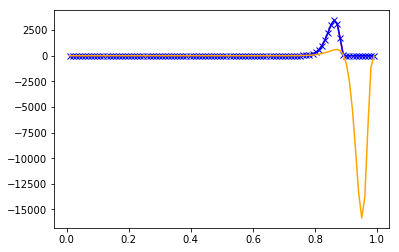

In [75]:
plt.plot(theta, worst_case_pos(theta).flatten(), 'red')
plt.plot(theta, worst_case_pos_interpolated(theta).flatten(), color = 'blue', marker = 'x')
plt.plot(theta, np.dot(g_eta_nclust, linear_sens.total_influence_function(theta)), 
         color = 'orange')


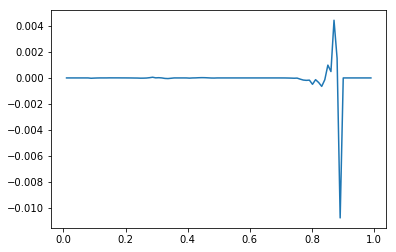

In [76]:
plt.plot(theta, worst_case_pos(theta).flatten() - worst_case_pos_interpolated(theta).flatten())

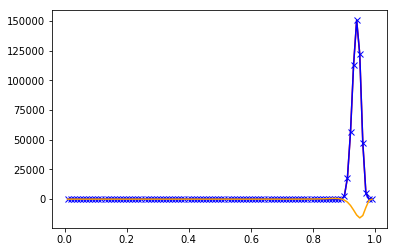

In [77]:
plt.plot(theta, worst_case_neg(theta).flatten(), 'red')
plt.plot(theta, worst_case_neg_interpolated(theta).flatten(), color = 'blue', marker = 'x')

plt.plot(theta, np.dot(g_eta_nclust, linear_sens.total_influence_function(theta)), 
         color = 'orange')


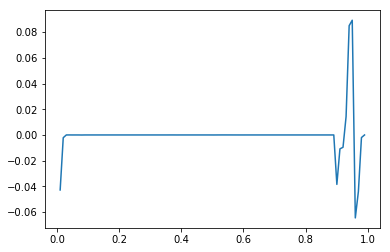

In [78]:
plt.plot(theta, worst_case_neg(theta).flatten() - worst_case_neg_interpolated(theta).flatten())

# Checking integration

In [147]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [148]:
u = lambda x : worst_case_pos_interpolated(x)
e_pert_prior = fun_sens_lib.dp_perturbed_prior(model.vb_params, model.prior_params,\
                                u = lambda x : u(x))

In [149]:
alpha = 4.0

In [150]:
dp_prior_density = lambda x : 1 / sp.special.beta(1, alpha) \
                            * (1 - x)**(alpha - 1)

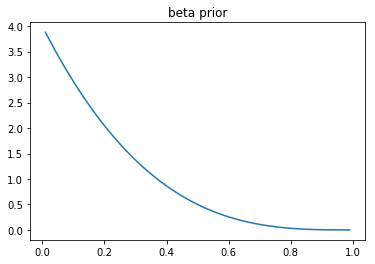

In [151]:
plt.plot(theta, dp_prior_density(theta))
plt.title('beta prior')

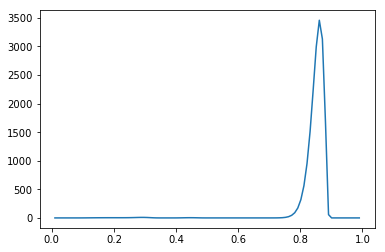

In [206]:
plt.plot(theta, u(theta))

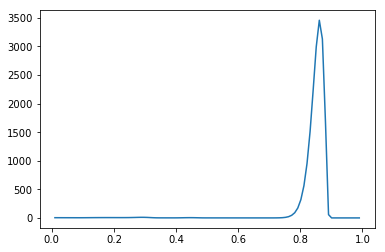

In [207]:
plt.plot(theta, u(theta) + dp_prior_density(theta))

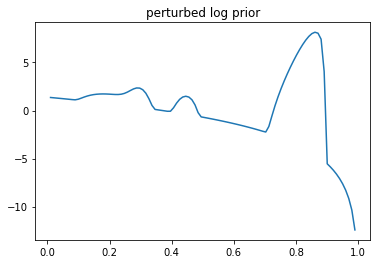

In [152]:
perturbed_log_density = lambda x : np.log(u(x) + dp_prior_density(x))
plt.plot(theta, perturbed_log_density(theta).flatten())
plt.title('perturbed log prior')

In [161]:
import scipy as osp

In [162]:
factor = 4.0
e_pert_prior_imp_sample = np.zeros(k_approx - 1)
for k in range(k_approx - 1): 

    lognorm_means = model.vb_params['global']['v_sticks']['mean'].get()[k]
    lognorm_infos = model.vb_params['global']['v_sticks']['info'].get()[k]

    samples = sp.special.expit(\
            osp.stats.norm.rvs(lognorm_means, factor / np.sqrt(lognorm_infos), 100000))
    # samples = np.minimum(samples, 1. - 1e-12)

    integrand = lambda x : perturbed_log_density(x) * \
                    np.exp(fun_sens_lib.get_log_logitnormal_density(x, lognorm_means, lognorm_infos) - 
                           fun_sens_lib.get_log_logitnormal_density(x, lognorm_means, lognorm_infos / factor**2))

    e_pert_prior_imp_sample[k] = np.mean(integrand(samples))

In [163]:
e_pert_prior_imp_sample

array([1.15673243, 0.02400576, 1.32052841, 6.17328092, 1.2404809 ,
       1.31091278, 1.28098771, 1.2615724 , 1.25193198, 1.25999521,
       1.25050671])

In [164]:
e_pert_prior

array([1.06820932, 0.07707168, 1.31851018, 0.60244975, 1.50991024,
       1.33027017, 1.20259295, 1.17877475, 1.17605358, 1.17805535,
       1.18187348])

In [165]:
# get functional sensitivity
worst_case_fun_sens_mat_pos, worst_case_fun_sens_mat_neg = \
    linear_sens.get_worst_case_fun_sens(g_eta_nclust)

In [166]:
worst_case_fun_sens_mat_pos_ = np.zeros((len(best_param), k_approx - 1))
worst_case_fun_sens_mat_neg_ = np.zeros((len(best_param), k_approx - 1))
for k in range(k_approx - 1): 
    worst_case_fun_sens_mat_pos_[:, k] = \
        linear_sens.get_functional_sensitivity(lambda x : np.maximum(worst_case_pos_interpolated(x), 0.0), k)
    worst_case_fun_sens_mat_neg_[:, k] = \
        linear_sens.get_functional_sensitivity(lambda x : np.maximum(worst_case_neg_interpolated(x), 0.0), k)

In [167]:
# Perturb and re-optimize with positive perturbation
epsilon = 0.00001

model_worst_case_pos_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : worst_case_pos_interpolated(x) * epsilon)

pos_pert_worst_case_opt_free_param = \
    model_worst_case_pos_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.60190785666043
Iter: 10	 RMSE: 9.036914062655264	 Objective: -338.63263837231347
Iter: 20	 RMSE: 9.035182209182649	 Objective: -338.63625704911067
Iter: 30	 RMSE: 9.035574520142777	 Objective: -338.64314722210395
Iter: 40	 RMSE: 9.036345390495578	 Objective: -338.64603456403995
Iter: 50	 RMSE: 9.036796764612449	 Objective: -338.6472664033735
Iter: 60	 RMSE: 9.03683117825357	 Objective: -338.64741380840974
Iter: 70	 RMSE: 9.0368034312926	 Objective: -338.6474220560801
Iter: 80	 RMSE: 9.036796813882045	 Objective: -338.6474225013286
Iter: 90	 RMSE: 9.036788514738753	 Objective: -338.64742256844164
Iter: 100	 RMSE: 9.036788473934868	 Objective: -338.64742256863605
Iter: 110	 RMSE: 9.036788473934868	 Objective: -338.64742256863605
Iter: 120	 RMSE: 9.036788473934868	 Objective: -338.64742256863605
Iter: 130	 RMSE: 9.036788473934868	 Objective: -338.6474225686363
Iter: 140	 RMSE: 9.036788474041296	 Objective: -338.6474225686339
         Curre

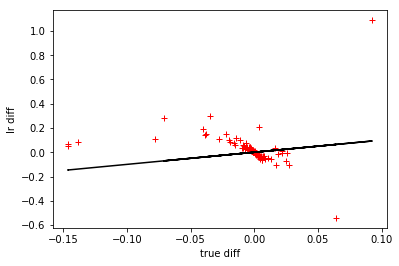

In [168]:
lr_free_param_diff_vec = np.matmul(worst_case_fun_sens_mat_pos_, epsilon * np.ones(k_approx - 1))

diff_vec = pos_pert_worst_case_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [169]:
get_e_number_clusters_from_free_par(model, best_param)

6.299604084399214

In [170]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pos_pert_worst_case_opt_free_param))

perturbed e_number_clusters: 6.206460100445173


In [171]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 7.120140164944945


In [201]:
# Perturb and re-optimize with positive perturbation
epsilon = 0.2

model_worst_case_neg_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : worst_case_neg_interpolated(x) * epsilon)

neg_pert_worst_case_opt_free_param = \
    model_worst_case_neg_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -347.5661408206834
Iter: 10	 RMSE: 9.144092447798227	 Objective: -354.8137896488398
Iter: 20	 RMSE: 9.124588212678598	 Objective: -355.0796321050114
Iter: 30	 RMSE: 9.165063161941726	 Objective: -356.2350046098709
Iter: 40	 RMSE: 9.1758362152754	 Objective: -357.31536568152677
Iter: 50	 RMSE: 9.173774939031194	 Objective: -358.2142833493814
Iter: 60	 RMSE: 9.188553591439824	 Objective: -359.4486408603072
Iter: 70	 RMSE: 9.182398145841832	 Objective: -359.7348151516146
Iter: 80	 RMSE: 9.180476134375242	 Objective: -359.93149766144006
Iter: 90	 RMSE: 9.184767337614856	 Objective: -359.97927834678285
Iter: 100	 RMSE: 9.181795318319526	 Objective: -360.01150470068234
Iter: 110	 RMSE: 9.18155857709813	 Objective: -360.0125757537225
Iter: 120	 RMSE: 9.1815947868028	 Objective: -360.01270919641337
         Current function value: -360.012717
         Iterations: 100
         Function evaluations: 126
         Gradient evaluations: 126
Iter: 130	 RM

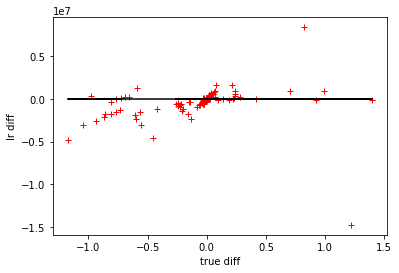

In [202]:
lr_free_param_diff_vec = np.matmul(worst_case_fun_sens_mat_neg_, epsilon * np.ones(k_approx - 1))

diff_vec = neg_pert_worst_case_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [203]:
get_e_number_clusters_from_free_par(model, best_param)

6.305623241909054

In [204]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, neg_pert_worst_case_opt_free_param))

perturbed e_number_clusters: 4.615038649310584


In [205]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 1.0


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [185]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [186]:
epsilons = np.array([1, 2, 3, 4, 5, 6, 7, 8]) * 0.0000001

In [188]:
pert_opt_free_param_list = []

# re-optimize for each epsilon
for i in tqdm(range(len(epsilons))): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    model.set_from_global_free_par(best_param)
    model.prior_params.set_free(prior_free_params)
    
    model_u_pert = gmm_utils.DPGaussianMixture(
        model.y, model.k_approx, model.prior_params, gh_deg = 8, \
        use_bnp_prior = model.vb_params.use_bnp_prior, \
        use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
        u = lambda x : worst_case_neg_interpolated(x) * epsilons[i])
    
    pert_opt_free_param_list.append(
        model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = True)[0])


  0%|          | 0/8 [00:00<?, ?it/s]

optimizing when epsilon = 1e-07
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.5285037284912
Iter: 10	 RMSE: 9.07992545553608	 Objective: -339.3521495626297
Iter: 20	 RMSE: 9.08514640936851	 Objective: -339.43810086387464
Iter: 30	 RMSE: 9.078706336291662	 Objective: -339.5614926077841
Iter: 40	 RMSE: 9.08737151498947	 Objective: -339.529029877973
Iter: 50	 RMSE: 9.093684936743339	 Objective: -339.68706637218446
Iter: 60	 RMSE: 9.096284502437918	 Objective: -339.7090383777621
Iter: 70	 RMSE: 9.093151349911398	 Objective: -339.74312564468835
Iter: 80	 RMSE: 9.092804277189565	 Objective: -339.74571107826404
Iter: 90	 RMSE: 9.092683190796429	 Objective: -339.74575273768386
Iter: 100	 RMSE: 9.09269850246396	 Objective: -339.74575449306224
Iter: 110	 RMSE: 9.092694274177507	 Objective: -339.7457545790007
Optimization terminated successfully.
         Current function value: -339.745755
         Iterations: 95
         Function evaluations: 114
         Gradient evaluations: 114


 12%|█▎        | 1/8 [00:15<01:49, 15.58s/it]

         Current function value: -339.745755
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0003960018980321031, f_diff = 4.1154635255225003e-10
optimizing when epsilon = 2e-07
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.6988160138284
Iter: 10	 RMSE: 9.092802300289849	 Objective: -339.70097073437717
Iter: 20	 RMSE: 9.075107886525588	 Objective: -339.974981367733
Iter: 30	 RMSE: 9.079308578485463	 Objective: -340.19130323766666
Iter: 40	 RMSE: 9.088336052457745	 Objective: -340.2882710241915
Iter: 50	 RMSE: 9.08706156468234	 Objective: -340.3243175469208
Iter: 60	 RMSE: 9.096802319831957	 Objective: -340.3424654764142
Iter: 70	 RMSE: 9.093037063699047	 Objective: -340.3828800010007
Iter: 80	 RMSE: 9.093206114250135	 Objective: -340.38488119770454
Iter: 90	 RMSE: 9.093300431033807	 Objective: -340.38492736146213
Iter: 100	 RMSE: 9.093268619823974	 Objective: -340.3849308980818
Iter: 110	 RM

 25%|██▌       | 2/8 [00:33<01:39, 16.57s/it]

         Current function value: -340.384931
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 6
         Hessian evaluations: 0
Iter 1: x_diff = 1.7721012307805764e-07, f_diff = 5.5706550483591855e-11
optimizing when epsilon = 3e-07
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.81881785955727
Iter: 10	 RMSE: 9.094569558979858	 Objective: -340.0272257491039
Iter: 20	 RMSE: 9.07838256664892	 Objective: -340.31688510611724
Iter: 30	 RMSE: 9.091536064402133	 Objective: -340.48285625444066
Iter: 40	 RMSE: 9.084353621895168	 Objective: -340.67681133213677
Iter: 50	 RMSE: 9.08973009364687	 Objective: -340.7166388630365
Iter: 60	 RMSE: 9.0929028018818	 Objective: -340.7614392904011
Iter: 70	 RMSE: 9.092948890499768	 Objective: -340.77126693257276
Iter: 80	 RMSE: 9.093418924260943	 Objective: -340.77156112445203
Iter: 90	 RMSE: 9.093413892077134	 Objective: -340.77157005900006
Iter: 100	 RMSE: 9.093423024717197	 Objective: -340.77157062314643
Iter: 11

 38%|███▊      | 3/8 [00:50<01:24, 16.90s/it]

Iter: 140	 RMSE: 9.093420490459849	 Objective: -340.7715706554858
         Current function value: -340.771571
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 7.197052281048e-08, f_diff = 1.0686562745831907e-11
optimizing when epsilon = 4e-07
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.9134664269716
Iter: 10	 RMSE: 9.095613872921893	 Objective: -340.27132444098504
Iter: 20	 RMSE: 9.080955073502961	 Objective: -340.57395285862964
Iter: 30	 RMSE: 9.083489900765501	 Objective: -340.92193362573164
Iter: 40	 RMSE: 9.08721655058465	 Objective: -340.9581342138314
Iter: 50	 RMSE: 9.09070032298546	 Objective: -340.9916884252644
Iter: 60	 RMSE: 9.091520766783908	 Objective: -341.028626729776
Iter: 70	 RMSE: 9.093284491064288	 Objective: -341.04873718054665
Iter: 80	 RMSE: 9.093506856368785	 Objective: -341.04925887874583
Iter: 90	 RMSE: 9.093497441639546	 Objective: -341.04927099074126
Iter: 100	 RM

 50%|█████     | 4/8 [01:05<01:05, 16.25s/it]

         Current function value: -341.049271
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0004258424300538925, f_diff = 4.774278750119265e-10
optimizing when epsilon = 5e-07
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.9921707042274
Iter: 10	 RMSE: 9.095513541814084	 Objective: -340.46647403494615
Iter: 20	 RMSE: 9.079472584552631	 Objective: -340.77797103627626
Iter: 30	 RMSE: 9.07823635674483	 Objective: -341.14627167756885
Iter: 40	 RMSE: 9.08833842013536	 Objective: -341.12171069426836
Iter: 50	 RMSE: 9.09189519827749	 Objective: -341.211999436606
Iter: 60	 RMSE: 9.090345871699173	 Objective: -341.2571199795144
Iter: 70	 RMSE: 9.093587866355161	 Objective: -341.2658396348287
Iter: 80	 RMSE: 9.093522861465518	 Objective: -341.2660862691231
Iter: 90	 RMSE: 9.093545342340951	 Objective: -341.2660971379472
Iter: 100	 RMSE: 9.093548237690735	 Objective: -341.26609754393604
Iter: 110	 RMSE

 62%|██████▎   | 5/8 [01:22<00:49, 16.46s/it]

         Current function value: -341.266098
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 6
         Hessian evaluations: 0
Iter 1: x_diff = 1.0340454382996248e-08, f_diff = 5.9685589803848416e-12
optimizing when epsilon = 6e-07
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.05974011059203
Iter: 10	 RMSE: 9.096303042592416	 Objective: -340.6336489837623
Iter: 20	 RMSE: 9.081141028394708	 Objective: -340.9631728099101
Iter: 30	 RMSE: 9.079199978367125	 Objective: -341.3244684932738
Iter: 40	 RMSE: 9.088103025037375	 Objective: -341.3536316715521
Iter: 50	 RMSE: 9.093638579962132	 Objective: -341.389319621596
Iter: 60	 RMSE: 9.094363868750074	 Objective: -341.42799898885704
Iter: 70	 RMSE: 9.093404731602329	 Objective: -341.4435738173296
Iter: 80	 RMSE: 9.09357739213395	 Objective: -341.44399326449235
Iter: 90	 RMSE: 9.093587794935376	 Objective: -341.4440077415547
Iter: 100	 RMSE: 9.093591087646256	 Objective: -341.4440080430319
Iter: 110	 

 75%|███████▌  | 6/8 [01:39<00:33, 16.63s/it]

         Current function value: -341.444008
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 5
         Hessian evaluations: 0
Iter 1: x_diff = 5.6369925938582876e-08, f_diff = 2.802380549837835e-11
optimizing when epsilon = 7e-07
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.11902958521534
Iter: 10	 RMSE: 9.0966344553115	 Objective: -340.7749506160089
Iter: 20	 RMSE: 9.08154854986977	 Objective: -341.11534681896137
Iter: 30	 RMSE: 9.07976163882605	 Objective: -341.47215504271395
Iter: 40	 RMSE: 9.088228589440753	 Objective: -341.40985291186365
Iter: 50	 RMSE: 9.093296448866466	 Objective: -341.5391626611626
Iter: 60	 RMSE: 9.093185938211827	 Objective: -341.58149391602467
Iter: 70	 RMSE: 9.093418654893219	 Objective: -341.5945455340965
Iter: 80	 RMSE: 9.093638189389997	 Objective: -341.5948735287618
Iter: 90	 RMSE: 9.093622747377308	 Objective: -341.59488387858244
Iter: 100	 RMSE: 9.093620415682558	 Objective: -341.59488413826955
Iter: 110	

 88%|████████▊ | 7/8 [01:57<00:16, 16.82s/it]

         Current function value: -341.594884
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 4
         Hessian evaluations: 0
Iter 1: x_diff = 1.7867070266203958e-07, f_diff = 3.61524143954739e-11
optimizing when epsilon = 8e-07
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.1718945691207
Iter: 10	 RMSE: 9.096810346705642	 Objective: -340.89891476991573
Iter: 20	 RMSE: 9.081784381193126	 Objective: -341.2461722411428
Iter: 30	 RMSE: 9.0804968610638	 Objective: -341.59748162657445
Iter: 40	 RMSE: 9.0877032345035	 Objective: -341.56522524019204
Iter: 50	 RMSE: 9.092234353323471	 Objective: -341.6683531084709
Iter: 60	 RMSE: 9.096187249160462	 Objective: -341.70873936922965
Iter: 70	 RMSE: 9.093050771222964	 Objective: -341.72530267226057
Iter: 80	 RMSE: 9.093619016499208	 Objective: -341.7258677094583
Iter: 90	 RMSE: 9.093654888450368	 Objective: -341.72588100857615
Iter: 100	 RMSE: 9.093653020073909	 Objective: -341.72588180189825
Iter: 110	 

100%|██████████| 8/8 [02:12<00:00, 16.53s/it]

Iter: 120	 RMSE: 9.093651584760561	 Objective: -341.7258818223467
         Current function value: -341.725882
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00014332737870651055, f_diff = 5.5081272876122966e-11


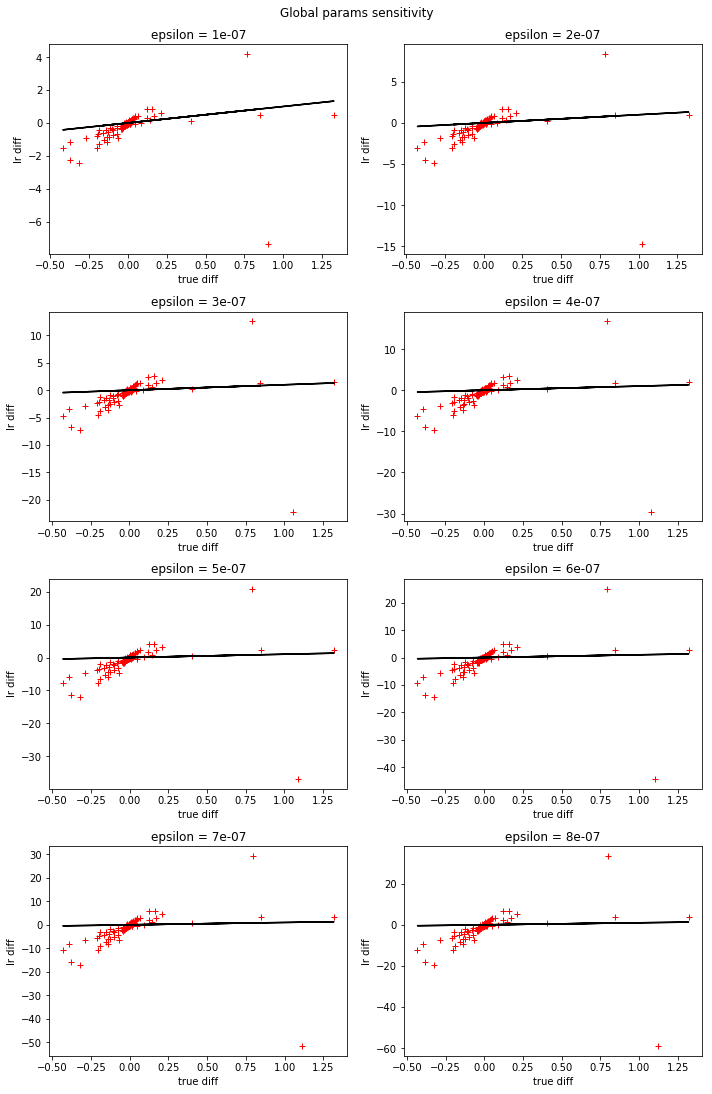

In [189]:
# check global params

# linear_sens.moment_model.set_moments_from_free_par(best_param)

# fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x))

f, axarr = plt.subplots(int(len(epsilons) / 2), 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
        
    # get linear response global free params
    lr_diff_vec = np.matmul(worst_case_fun_sens_mat_neg_, np.ones(k_approx - 1) * epsilons[i])

    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list[i] - best_param).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


(1e-07, 8e-07)

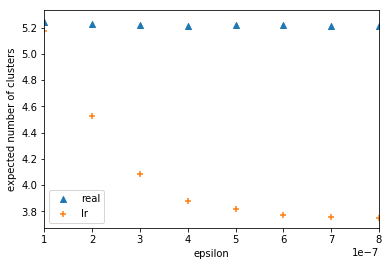

In [190]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list[i])
    
    lr_free_param_diff_vec = np.matmul(worst_case_fun_sens_mat_neg_, np.ones(k_approx - 1) * epsilons[i])
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.legend(('real', 'lr'))
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')
plt.legend(('real', 'lr'))
plt.xlim((epsilons[0], epsilons[-1]))